# DBSCAN model

The numeric dataset which have been chosen is the `glass dataset`. There are 3 main classes we should ditinguish:

- Windows with float treatment (build_wind_float and vehic_wind_float)
- Windows with no float treatment (build_wind_non_float)
- Non windows glass (containers, tableware, headlamps)

In [28]:
from src.read.processing import Processing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dataclass = Processing(source_path='input/datasets/')
df = dataclass.read('glass')

# Fix problem with K column name
df.columns = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

# Set class names from "Type" column
d_class = {'build_wind_float':'float', 'vehic_wind_float':'float',
           'build_wind_non-float':'non_float', 'containers':'non_wind', 
           'tableware':'non_wind', 'headlamps':'non_wind'}

df['Class'] = df['Type'].map(d_class)
df = df[df['Class'].isin(['float', 'non_float'])]
d_class_num = {"non_float":0, "float":1}
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,Class
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.00,0.00,build_wind_float,float
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.00,0.00,vehic_wind_float,float
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,build_wind_float,float
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.00,0.24,build_wind_non-float,non_float
5,1.51655,12.75,2.85,1.44,73.27,0.57,8.79,0.11,0.22,build_wind_non-float,non_float


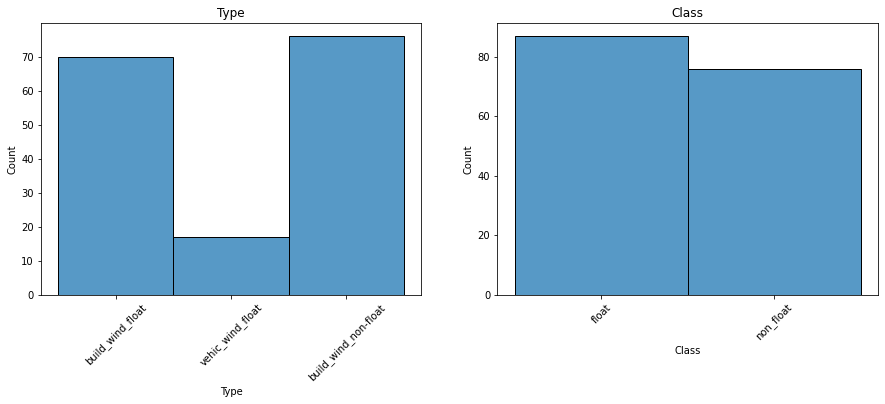

In [29]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x='Type', ax=ax[0])
sns.histplot(data=df, x='Class', ax=ax[1])
ax[0].set_title('Type')
ax[1].set_title('Class')

# rotate x-axis labels
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

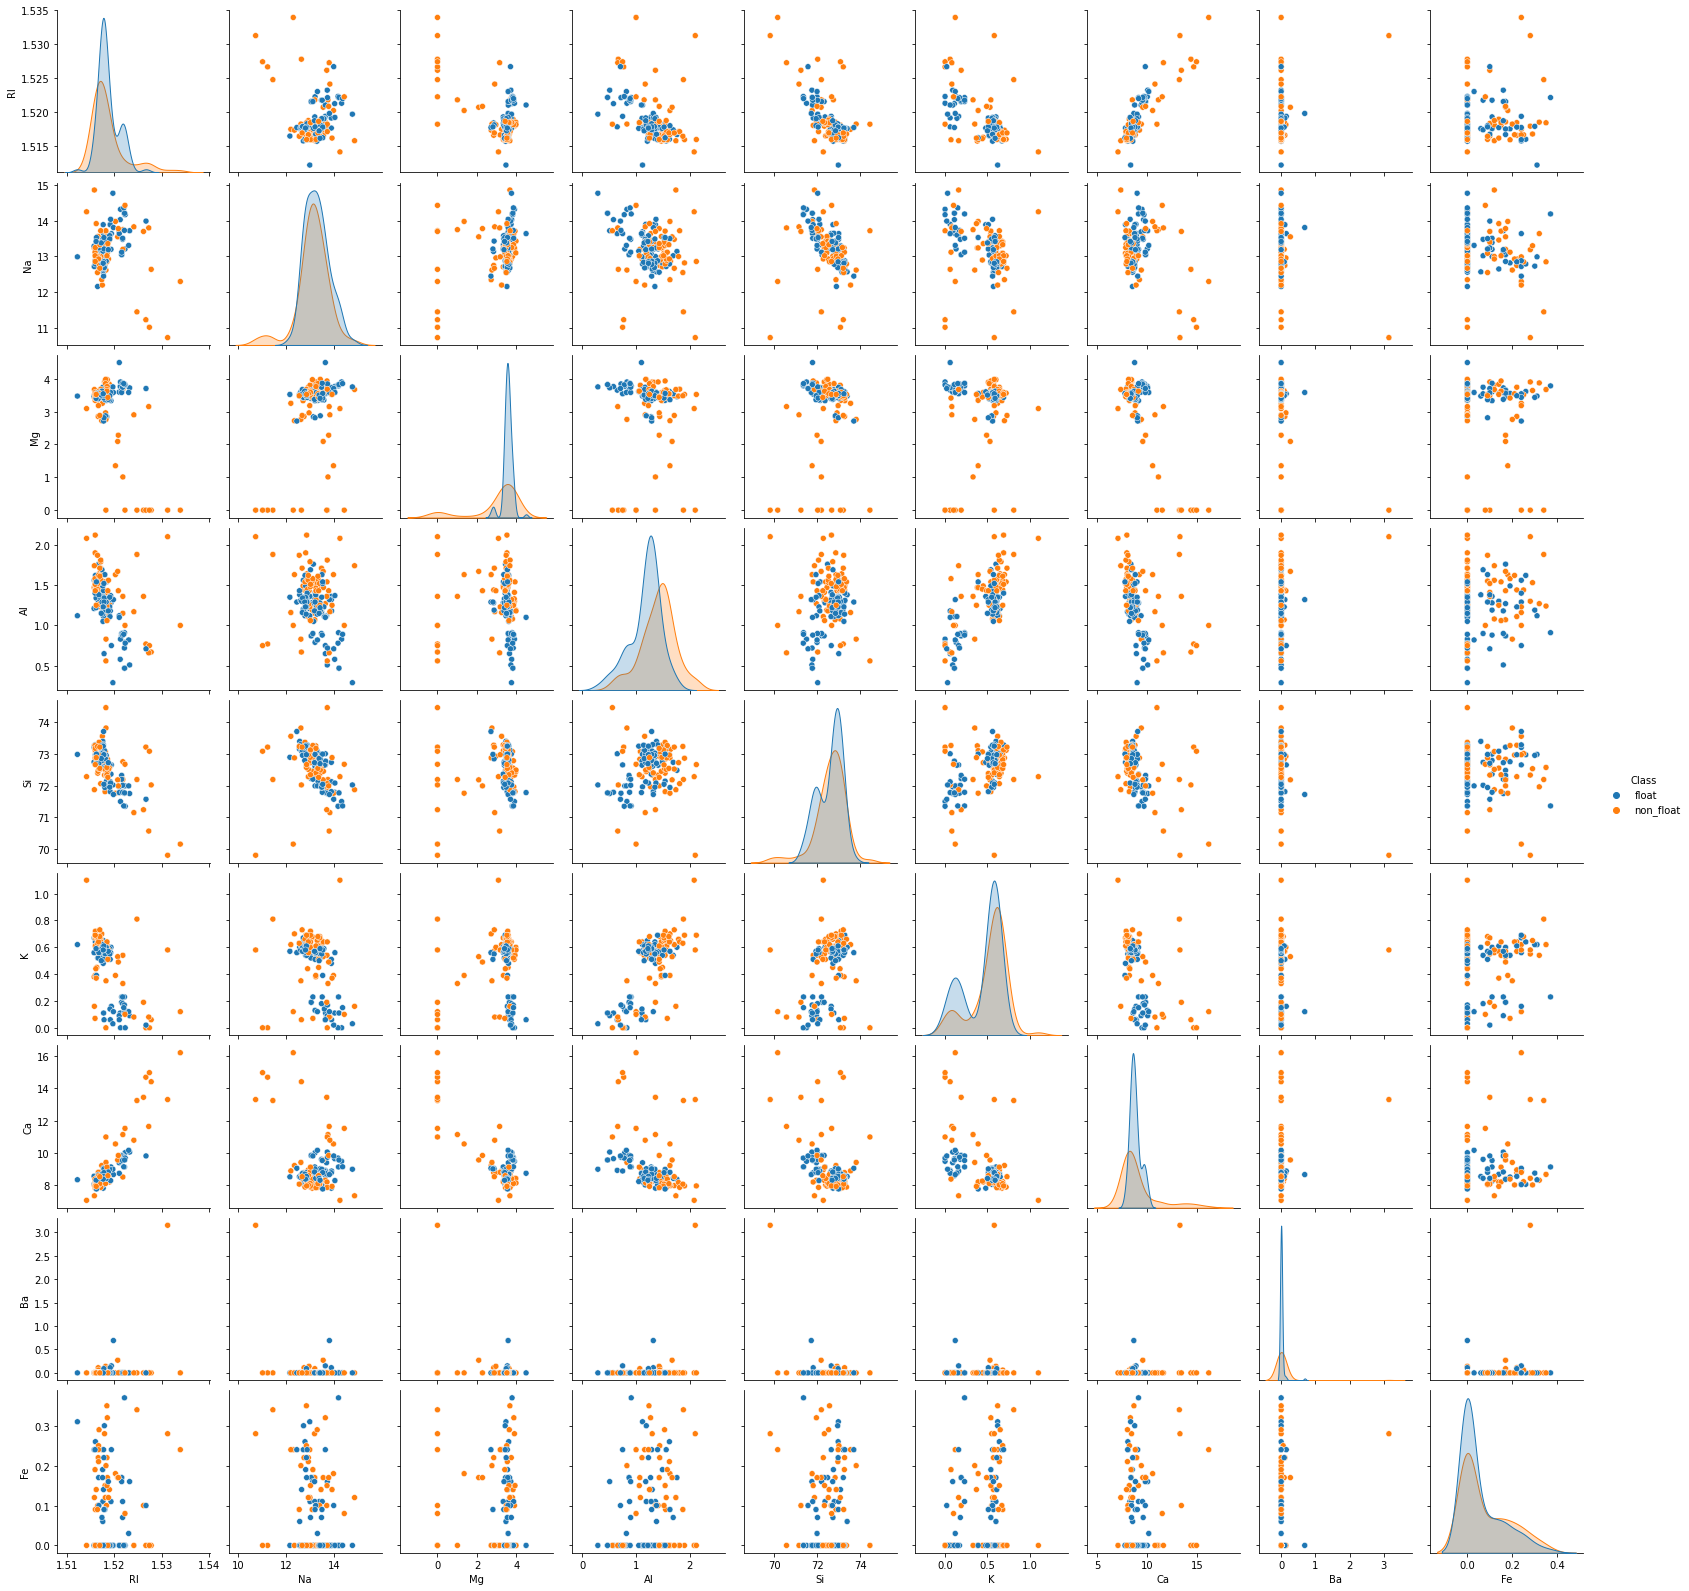

In [30]:
sns.pairplot(df, hue='Class')
plt.savefig('notebooks/dbscan/figs/pairplot.png');

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


<AxesSubplot:title={'center':'Variation Coefficient'}>

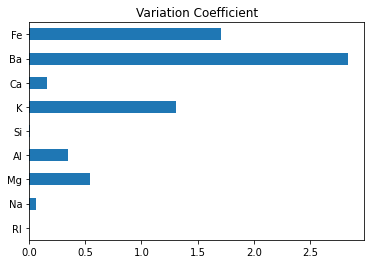

In [6]:
df.select_dtypes(include=float).apply(lambda x: x.std()/x.mean()).plot.barh(title="Variation Coefficient")

In [31]:
df_agg = df.groupby('Class').agg(['mean', 'std'])
df_agg

RI                   Na                  Mg            \
               mean       std       mean       std      mean       std   
Class                                                                    
float      1.518571  0.002214  13.280345  0.503842  3.550690  0.232183   
non_float  1.518619  0.003802  13.111711  0.664159  3.002105  1.215661   

                 Al                   Si                   K            \
               mean       std       mean       std      mean       std   
Class                                                                    
float      1.171149  0.287319  72.577241  0.562442  0.439425  0.217129   
non_float  1.408158  0.318340  72.598026  0.724573  0.521053  0.213726   

                 Ca                  Ba                  Fe            
               mean       std      mean       std      mean       std  
Class                                                                  
float      8.794483  0.540374  0.011954  0.076733  0.057011  0.092361  
non_float  9.073684  1.921635  0.050263  0.362340  0.079737  0.106433

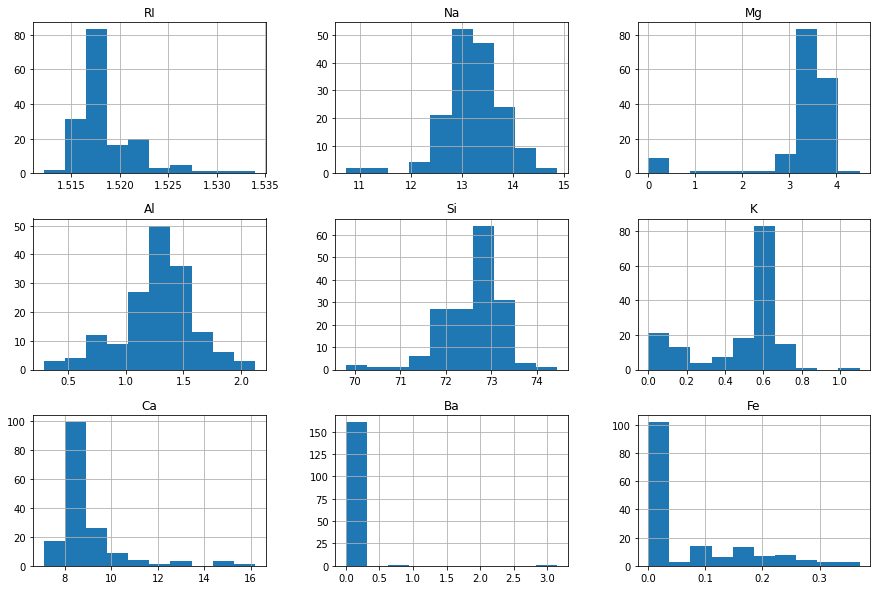

In [32]:
df.hist(figsize=(15, 10));

In [33]:
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, v_measure_score, confusion_matrix, classification_report

cols = ["Fe", "Ba", "K", "Al", "Mg"]
X = df[cols]
y = df['Class'].map(d_class_num).values.reshape(-1, 1)

model_dbs = Pipeline([
                        ('scaler', StandardScaler()),
                        ('model', Birch())
                    ])

model_dbs.fit(X)

y_pred = model_dbs['model'].labels_.reshape(-1, 1)

print(f"Silhouette score: {silhouette_score(X, y_pred)}")

Silhouette score: 0.7955242340058193


/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


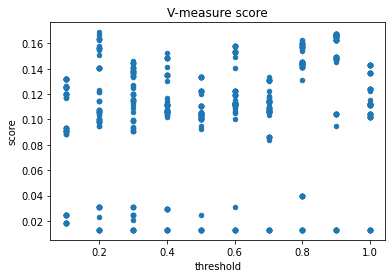

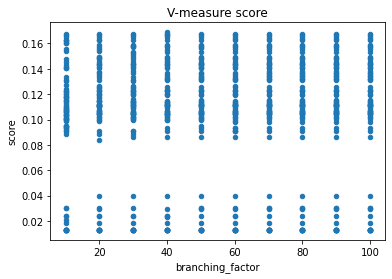

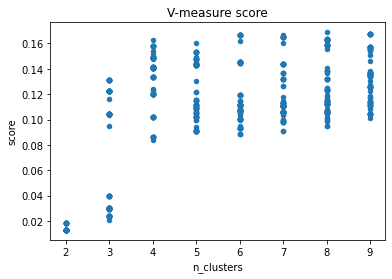

In [34]:
def check_hyp(X, y=None, scorer=silhouette_score,  **model_kwargs):

    model = Pipeline([
                          ('scaler', StandardScaler()),
                          ('model', Birch(**model_kwargs))
                     ])

    model.fit(X)
    y_pred = model['model'].labels_.reshape(-1, 1).ravel()

    if y is not None:
        return scorer(y, y_pred)
    else:
        return scorer(y_pred)

grid = {'threshold': np.linspace(0.1, 1, 10),
        'branching_factor':np.linspace(10, 100, 10, dtype=int),
        'n_clusters':np.arange(2, 10)}

from itertools import product
# Create a list of all possible hyperparameter combinations
combinations = list(product(*grid.values()))

# Print the grid of hyperparameter combinations
ls_hyps = []
for combo in combinations:
    hyperparameters = dict(zip(grid.keys(), combo))
    ls_hyps.append(hyperparameters)

ls_d_scores = []
for d_grid in ls_hyps:
    d_grid['score'] = check_hyp(X, y.ravel(), v_measure_score, **d_grid)
    ls_d_scores.append(d_grid)

df_scores = pd.DataFrame(ls_d_scores)

for hp in grid.keys():
    df_scores.plot(x=hp, y='score', title='V-measure score', kind='scatter')
    plt.show()

In [35]:
df_scores.sort_values(by='score', ascending=False).head(10)

,threshold,branching_factor,n_clusters,score
110,0.2,40,8,0.168778
647,0.9,10,9,0.167642
655,0.9,20,9,0.167642
679,0.9,50,9,0.167642
719,0.9,100,9,0.167642
711,0.9,90,9,0.167642
671,0.9,40,9,0.167642
687,0.9,60,9,0.167642
663,0.9,30,9,0.167642
695,0.9,70,9,0.167642


In [37]:
df_scores[df_scores['n_clusters']==2].sort_values(by='score', ascending=False).head(10)

,threshold,branching_factor,n_clusters,score
0,0.1,10,2,0.018323
16,0.1,30,2,0.018323
24,0.1,40,2,0.018323
32,0.1,50,2,0.018323
40,0.1,60,2,0.018323
48,0.1,70,2,0.018323
56,0.1,80,2,0.018323
64,0.1,90,2,0.018323
72,0.1,100,2,0.018323
8,0.1,20,2,0.018323


(array([ 11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 152.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

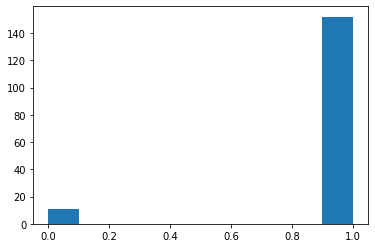

In [39]:
birch = Birch(threshold=0.1, branching_factor=20, n_clusters=2)
birch.fit(X)
y_pred = birch.labels_.reshape(-1, 1)
plt.hist(y_pred)

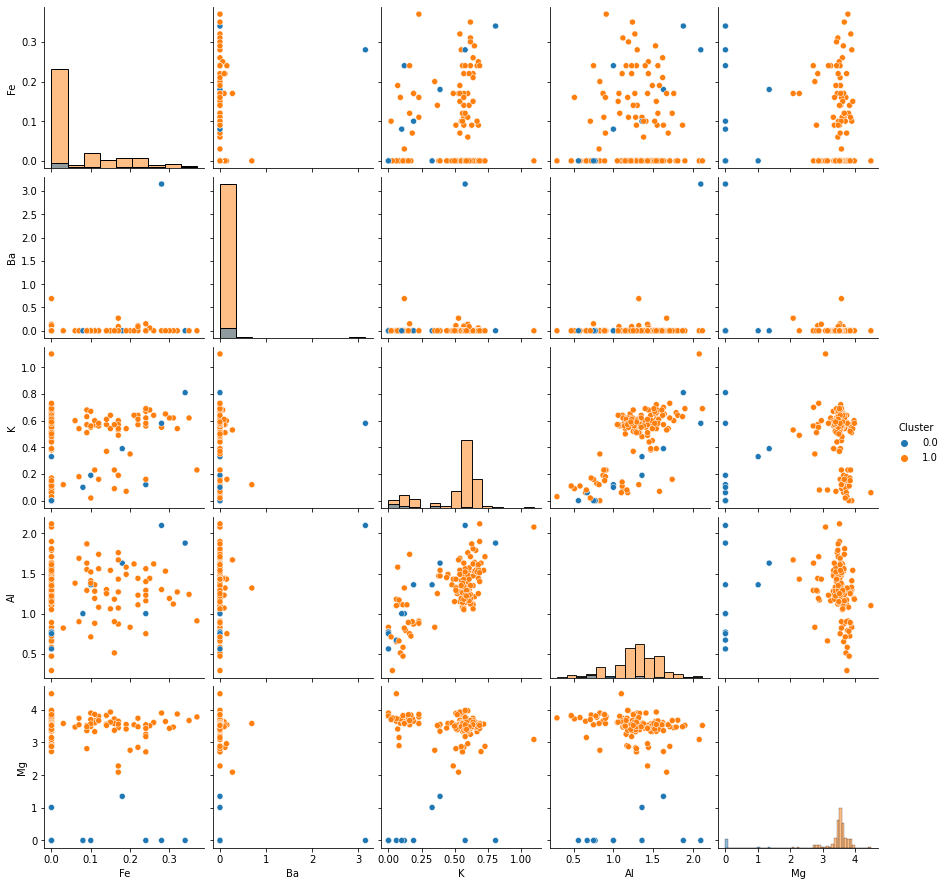

In [40]:
df_out = pd.DataFrame(np.hstack((X, y_pred)), columns=cols+['Cluster'])
sns.pairplot(df_out, hue='Cluster', diag_kind='hist')

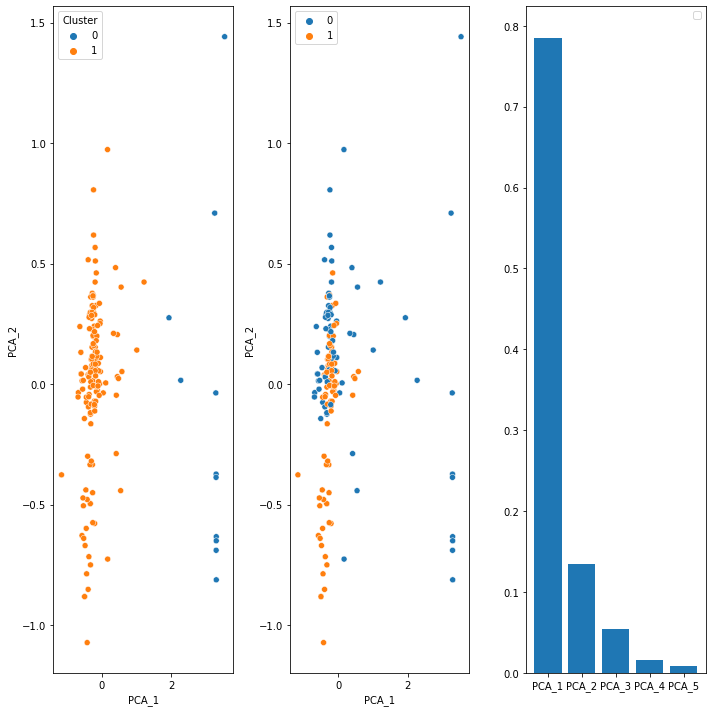

In [42]:
from sklearn.decomposition import PCA

pca_mod = PCA(n_components=X.shape[1])
pca_mod.fit(X)
X_pca = pca_mod.transform(X)
df_pca = pd.DataFrame(X_pca, columns=[f"PCA_{i}" for i in np.arange(1, X.shape[1]+1)])
df_pca['Cluster'] = y_pred
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

sns.scatterplot(x="PCA_1", y="PCA_2", hue="Cluster", cmap='viridis', data=df_pca, ax=ax[0])
sns.scatterplot(x="PCA_1", y="PCA_2", hue=y.ravel(), cmap='viridis', data=df_pca, ax=ax[1])

ax[2].bar(height=pca_mod.explained_variance_ratio_, x=[f"PCA_{i}" for i in np.arange(1, X.shape[1]+1)])
plt.legend()
plt.tight_layout()

In [53]:
# get loadings
loadings = pca_mod.components_.T * np.sqrt(pca_mod.explained_variance_) 
df_loadings = pd.DataFrame(loadings, columns=[f"PCA_{i}" for i in np.arange(1, X.shape[1]+1)])
# df_loadings['Variable'] = cols
df_loadings = df_loadings.T
df_loadings.columns = cols
df_loadings

,Fe,Ba,K,Al,Mg
PCA_1,0.014153,0.078372,-0.049951,-0.003951,-0.887459
PCA_2,0.009647,0.077142,0.177196,0.315788,-0.004413
PCA_3,0.012852,0.227967,-0.046326,-0.029764,0.023077
PCA_4,-0.025966,-0.012411,-0.107360,0.064127,0.004247
PCA_5,0.093646,-0.007742,-0.016666,0.008406,0.001710


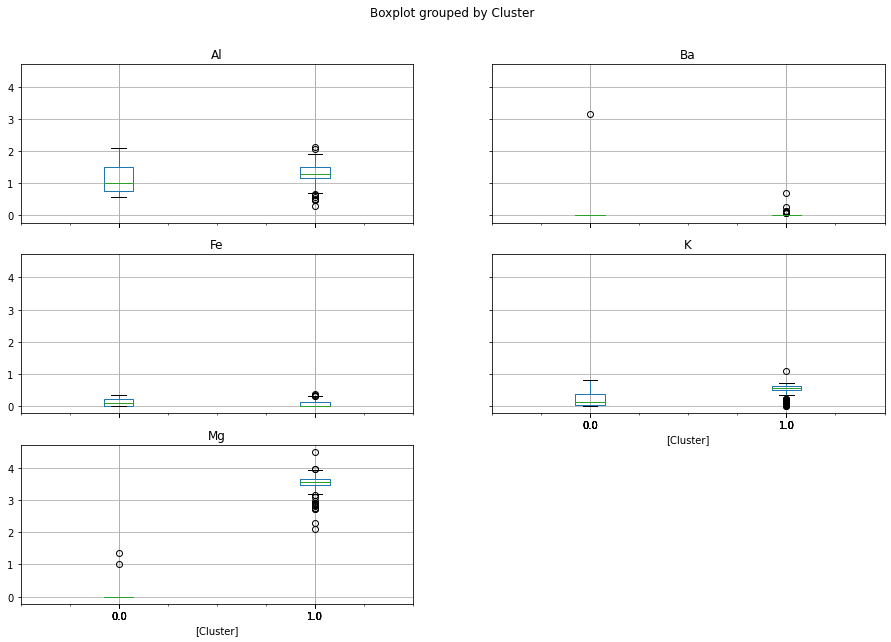

In [54]:
df_out.boxplot(by='Cluster', figsize=(15, 10));

In [ ]:


model = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN())
])



In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
    
# dbscan = Pipeline([('scaler', StandardScaler()), 
#                    ('model', DBSCAN())])
# gs = GridSearchCV(dbscan, param_grid={'model__eps':np.arange(0.1, 1.1, 0.1),
#                                       'model__min_samples':np.arange(1, 10)},
#                   scoring='v_measure_score',
#                   cv=3)

# gs.fit(X_train, y_train)

cv = KFold(n_splits=3, shuffle=True, random_state=0)
ls_scores = []
for train_index, val_index in cv.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    dbscan = Pipeline([('scaler', StandardScaler()), 
                       ('model', DBSCAN(eps=0.4, min_samples=2))])
    dbscan.fit(X_train_cv)
    y_pred = dbscan['model'].labels_.reshape(-1, 1)
    ls_scores.append(silhouette_score(y_train_cv, y_pred))

ls_scores

/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alberto/anaconda3/envs/iml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.6024803540702109, -0.8070175438596491, -0.7894736842105263]

In [38]:
ls_scores

[-0.460077934674278, -0.11113948792137252, -0.13538905402978849]